The dataset consists of 1440 files (both songs and speech): 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male). 

Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

Source: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Importing the libraries**

In [3]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# **2. Reading the data**

In [5]:
path = 'drive/MyDrive/ravdess/audio_speech_actors_01-24/'

In [6]:
ravdess_directory_list = os.listdir(path)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(path + dir)
    for file in actor:
        part = file.split('.')[0].split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(path + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
# 2 calm
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
#Ravdess_df = Ravdess_df.drop(Ravdess_df[Ravdess_df.Emotions=='neutral'].index)
Ravdess_df.head()

,Emotions,Path
0,calm,drive/MyDrive/ravdess/audio_speech_actors_01-2...
1,neutral,drive/MyDrive/ravdess/audio_speech_actors_01-2...
2,sad,drive/MyDrive/ravdess/audio_speech_actors_01-2...
3,sad,drive/MyDrive/ravdess/audio_speech_actors_01-2...
4,fear,drive/MyDrive/ravdess/audio_speech_actors_01-2...


We excluded 'neutral' from the dataset as it's quite similar to the calm expressions. Now all the classes are balanced.

# **3. Exploratory data analysis (EDA)**

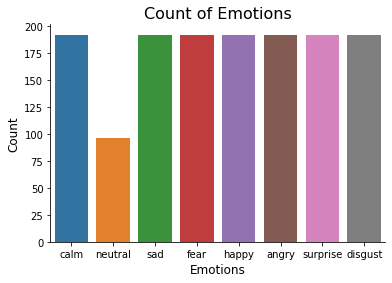

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show();

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

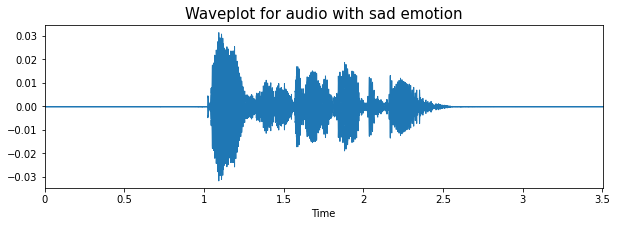

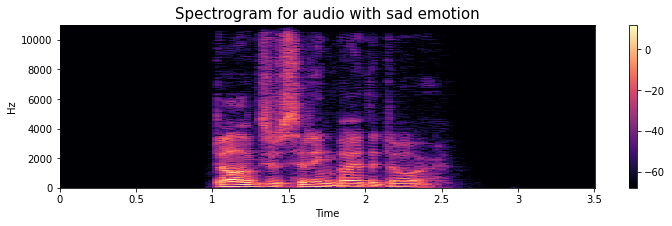

In [152]:
emotion='sad'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

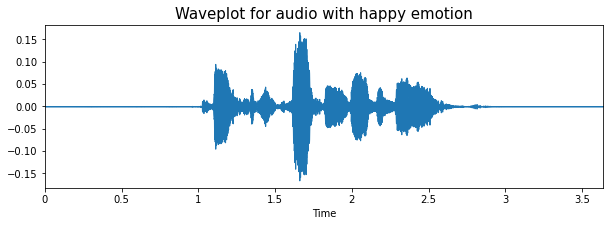

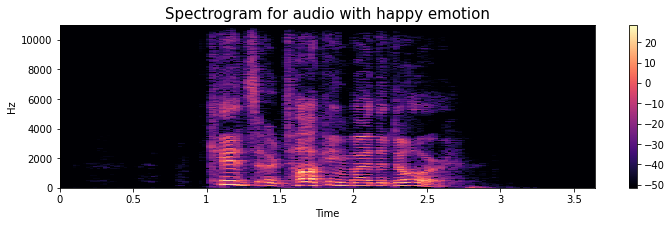

In [ ]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# **4. Augmentation of data**

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [10]:
# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[7]
data, sample_rate = librosa.load(path)

### **Original audio**

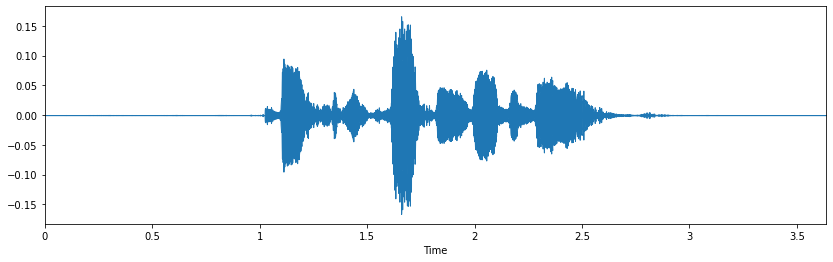

In [84]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

### **Noise**

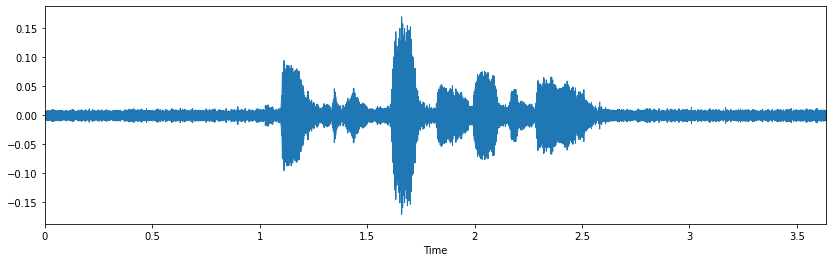

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### **Stretching**

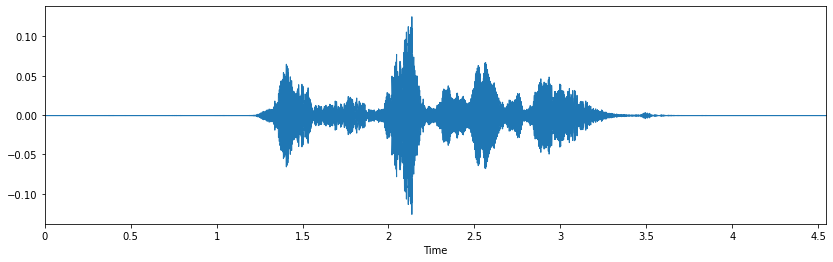

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### **Shift**

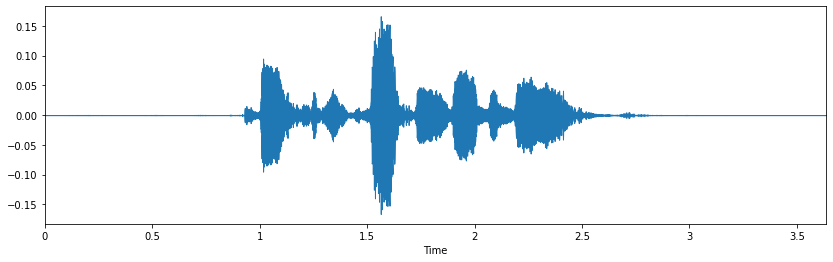

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### **Pitch**

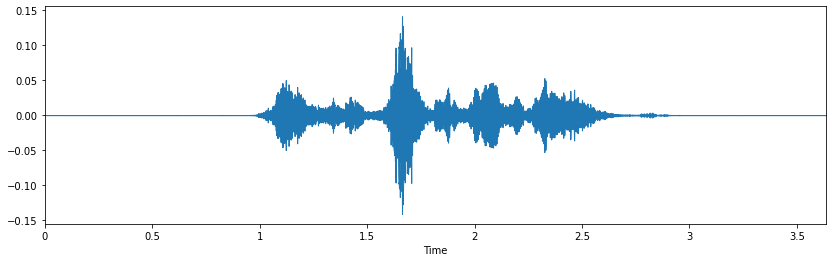

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [11]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

# **5. Preparing data for the model**

In [12]:
x, Y = [], []

for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        x.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [13]:
len(x), len(Y), Ravdess_df.Path.shape

(4320, 4320, (1440,))

In [14]:
df = pd.DataFrame(x)
df['labels'] = Y
# Features.to_csv('features.csv', index=False)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,labels
0,0.184828,0.595758,0.655787,0.727690,0.700262,0.663431,0.669693,0.665442,0.728932,0.689506,0.615418,0.630566,0.662267,-637.701233,104.299019,4.894947,20.494011,12.552953,2.851410,-6.633390,-4.091277,-10.423918,-6.406950,1.957149,0.172893,-1.170210,-5.292451,-0.573319,1.019471,-3.492606,-3.468123,-1.214944,1.971238,0.002221,5.398116e-06,0.000149,0.017077,0.047954,0.017243,0.000947,...,0.000004,3.010847e-06,5.900283e-06,8.286284e-06,0.000020,0.000033,0.000045,0.000051,0.000043,0.000024,0.000021,0.000024,0.000017,0.000025,0.000026,0.000013,0.000013,0.000014,0.000007,0.000004,0.000003,4.592336e-06,4.345120e-06,0.000006,4.691633e-06,4.936912e-06,4.081031e-06,2.651862e-06,1.534153e-06,1.691048e-06,1.724708e-06,1.696310e-06,2.040566e-06,3.192627e-06,5.844851e-06,6.540728e-06,5.534759e-06,2.244282e-06,1.209406e-07,calm
1,0.233032,0.693292,0.756801,0.797017,0.769612,0.764185,0.727971,0.687842,0.749485,0.732809,0.686758,0.721551,0.737806,-482.836579,42.256902,17.580529,11.969625,6.698274,1.430488,-3.116610,-5.203406,-5.709207,-5.213364,-0.649664,0.641346,-1.301037,-2.033020,-0.566114,-0.552186,-2.602391,-2.638594,0.638426,-1.177172,0.002405,2.531008e-05,0.000170,0.017182,0.047988,0.017268,0.000970,...,0.000025,2.468335e-05,2.678121e-05,3.017665e-05,0.000040,0.000054,0.000069,0.000072,0.000063,0.000044,0.000041,0.000044,0.000037,0.000045,0.000045,0.000033,0.000032,0.000035,0.000028,0.000024,0.000022,2.465401e-05,2.596871e-05,0.000028,2.549779e-05,2.422601e-05,2.285895e-05,2.274873e-05,2.182991e-05,2.200266e-05,2.278906e-05,2.235710e-05,2.254631e-05,2.416625e-05,2.672702e-05,2.619658e-05,2.580206e-05,2.384413e-05,2.115346e-05,calm
2,0.126841,0.647034,0.565610,0.647616,0.679484,0.625969,0.631253,0.655692,0.675821,0.708252,0.643280,0.618873,0.697093,-698.085876,99.795288,1.892867,19.915091,7.532692,1.265838,-9.189011,-5.797953,-12.299608,-4.976625,1.809412,-1.639930,-2.603518,-4.890360,-0.879432,-1.249962,-3.450204,-4.708112,-0.086886,-3.033479,0.001038,8.050654e-07,0.000013,0.001858,0.010739,0.009146,0.000214,...,0.000002,6.577337e-07,5.712229e-07,7.083623e-07,0.000002,0.000003,0.000008,0.000010,0.000012,0.000011,0.000007,0.000002,0.000004,0.000003,0.000005,0.000006,0.000004,0.000002,0.000002,0.000002,0.000001,8.589454e-07,9.515467e-07,0.000001,7.390356e-07,6.067640e-07,6.952486e-07,6.417013e-07,6.606053e-07,4.816234e-07,3.145873e-07,2.529582e-07,3.109917e-07,3.264611e-07,4.345452e-07,8.238660e-07,8.989096e-07,3.056366e-07,1.888682e-08,calm
3,0.297314,0.743129,0.754720,0.747343,0.733528,0.726183,0.682260,0.676388,0.701887,0.736036,0.695124,0.684309,0.707974,-644.859009,69.573090,2.603384,16.992235,7.469007,2.995507,-2.625710,-7.836775,-13.316399,-4.526955,-0.048874,-2.389072,-0.242245,-3.906938,-2.942740,1.678184,-6.506072,-2.595646,-0.604484,-0.405804,0.003320,2.997279e-06,0.000089,0.007546,0.036165,0.081686,0.017410,...,0.000176,1.480957e-04,1.832554e-04,1.394138e-04,0.000345,0.000642,0.000509,0.000455,0.000402,0.000211,0.000198,0.000175,0.000154,0.000183,0.000200,0.000124,0.000067,0.000067,0.000062,0.000025,0.000018,1.791678e-05,3.848192e-05,0.000044,2.679662e-05,2.694546e-05,3.007091e-05,2.133095e-05,1.577332e-05,1.624861e-05,1.986174e-05,1.858358e-05,2.485619e-05,8.028382e-05,4.014647e-05,3.653998e-05,3.107788e-05,1.029439e-05,6.636481e-07,neutral
4,0.339821,0.811854,0.818495,0.811566,0.825337,0.852712,0.789939,0.689277,0.726045,0.768984,0.755984,0.761305,0.770374,-407.431490,22.375993,10.299832,8.931987,3.685888,2.183707,-1.413667,-6.083225,-6.756905,-4.644207,-1.297783,-1.217454,-1.538440,-2.192224,-1.178592,-0.269705,-3.481448,-2.982165,0.006065,-2.082639,0.004102,1.277546e-04,0.000250,0.007725,0.036320,0.081440,0.017405,...,0.000295,2.729707e-04,3.359454e-0

In [15]:
x = df.iloc[: ,:-1].values
Y = df['labels'].values

In [16]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=0, shuffle=False)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [18]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [19]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

# **6. Building the model**

In [20]:
from tensorflow.keras import regularizers

model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1),
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 batch_normalization (BatchN  (None, 162, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 batch_normalization_1 (Batc  (None, 81, 256)          1024      
 hNormalization)                                                 
                                                        

In [21]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/200
51/51 [==============================] - 25s 436ms/step - loss: 2.3178 - accuracy: 0.2426 - val_loss: 2.2347 - val_accuracy: 0.1991 - lr: 0.0010
Epoch 2/200
51/51 [==============================] - 22s 429ms/step - loss: 2.0759 - accuracy: 0.2923 - val_loss: 2.4450 - val_accuracy: 0.1074 - lr: 0.0010
Epoch 3/200
51/51 [==============================] - 22s 434ms/step - loss: 1.9672 - accuracy: 0.3404 - val_loss: 2.7180 - val_accuracy: 0.1019 - lr: 0.0010
Epoch 4/200
51/51 [==============================] - 22s 431ms/step - loss: 1.9063 - accuracy: 0.3580 - val_loss: 2.7943 - val_accuracy: 0.1056 - lr: 0.0010
Epoch 5/200
51/51 [==============================] - 22s 433ms/step - loss: 1.8351 - accuracy: 0.3821 - val_loss: 2.7164 - val_accuracy: 0.1657 - lr: 0.0010
Epoch 6/200
51/51 [==============================] - 22s 434ms/step - loss: 1.7992 - accuracy: 0.4046 - val_loss: 2.7306 - val_accuracy: 0.1185 - lr: 0.0010
Epoch 7/200
51/51 [==============================] - 22s 4

34/34 [==============================] - 2s 45ms/step - loss: 3.5405 - accuracy: 0.3889
Accuracy of our model on test data :  38.88888955116272 %


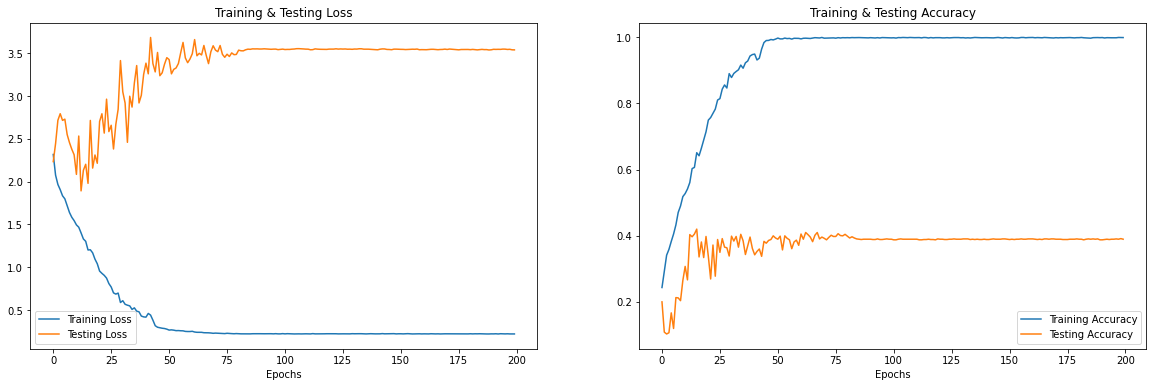

In [22]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# **7. Testing of model**

In [23]:
# predicting on test data
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [24]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,calm,happy
1,disgust,happy
2,happy,happy
3,calm,neutral
4,calm,neutral
5,calm,neutral
6,calm,calm
7,fear,calm
8,angry,calm
9,calm,sad


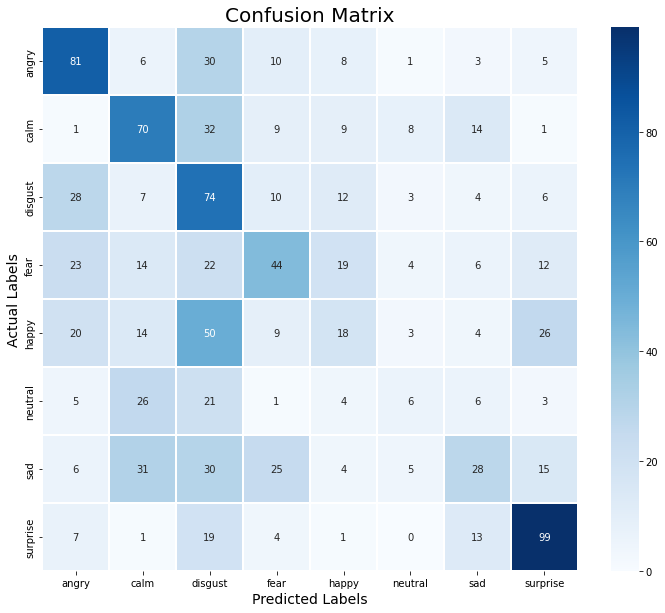

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.47      0.56      0.51       144
        calm       0.41      0.49      0.45       144
     disgust       0.27      0.51      0.35       144
        fear       0.39      0.31      0.34       144
       happy       0.24      0.12      0.16       144
     neutral       0.20      0.08      0.12        72
         sad       0.36      0.19      0.25       144
    surprise       0.59      0.69      0.64       144

    accuracy                           0.39      1080
   macro avg       0.37      0.37      0.35      1080
weighted avg       0.38      0.39      0.37      1080



# **8. Saving the model**

In [28]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://20cfe0ac-17bd-4128-8d09-8dcf218aaf09/assets
